In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
%matplotlib inline

In [3]:
df = pd.read_csv('openpowerlifting.csv',low_memory=False)

## Project : 
**Hypothesis:** Trying to see if there is a statistically signficant test in progression rate between older and younger people

In [4]:
df_new=df[df['MeetCountry']=='USA']
df_new=df[df['Equipment']=='Raw']
df_new=df[df['Tested']=='Yes'] #could have used & but tried to separate :)

df_new=df_new.sort_values('Date')[['Name','Sex','Equipment','Age','TotalKg','Date','Best3SquatKg','Best3BenchKg','Best3DeadliftKg']].dropna()

#Select names appearn in at least 3 meets
names =df_new['Name'].value_counts()[df_new['Name'].value_counts()>2].index.tolist()
df_new=df_new[df_new['Name'].isin(names)]

#Change the date to timestamp to calculate the diff 
df_new['Date']=pd.to_datetime(df_new['Date'])

In [5]:
#Function thats reflects an average progression of a lifter 

def progression(test):
    max= test['TotalKg'].max()
    min= test['TotalKg'].min()
    diffKg = max-min 
    temps_delta = test.loc[test["TotalKg"].idxmax()]['Date']-test.loc[test["TotalKg"].idxmin()]['Date']
    return diffKg/float(temps_delta.days)

#Separate by two groups under 30 and plus30, then calculating the progression by days
df_p30=df_new[df_new['Age']>=30]
df_u30=df_new[df_new['Age']<30]

p_u30=df_u30.groupby('Name').apply(progression)
p_p30=df_p30.groupby('Name').apply(progression)

#Dropping negative values and infinite (which means they regressed in every meet after the first)
p_p30 = p_p30.where(p_p30>0)
p_u30 = p_u30.where(p_u30>0)
p_p30=p_p30.replace([np.inf, -np.inf], np.nan).dropna()
p_u30=p_u30.replace([np.inf, -np.inf], np.nan).dropna()

#Putting them in one dataframe
p_p30=p_p30.to_frame()
p_u30=p_u30.to_frame()
p_p30['Cat'] ='30y++'
p_u30['Cat'] ='30y--'

#The result Dataframe
result=pd.concat([p_p30,p_u30])
result.rename(columns={0:'progression'},inplace=True)
result.head()

C:\Users\PADS08191\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\PADS08191\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


,progression,Cat
Name,,
A. Gonzales,0.153159,30y++
A. Green,0.210472,30y++
AJ Halbach,0.013130,30y++
Aaron Bate,0.027174,30y++
Aaron Ecton,0.018107,30y++


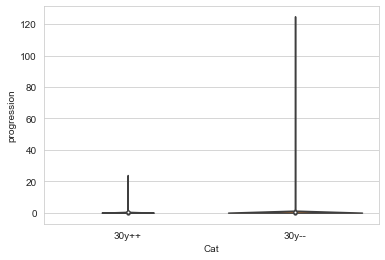

In [6]:
#Plotting directly without removing outliers
sns.violinplot(x='Cat',y='progression',data=result,scale='count',cut=0)

We see that we need to delete the outliers to have a better look at the data.

In [9]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

outlier = remove_outlier(result,'progression')

pmean=round(float(outlier[outlier['Cat']=='30y++'].mean().values),2)
umean=round(float(outlier[outlier['Cat']=='30y--'].mean().values),2)

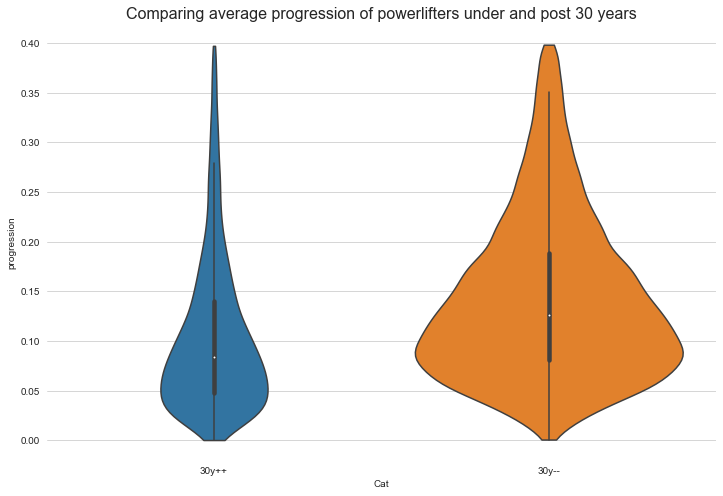

In [39]:
plt.figure(figsize=(12,8))
plt.title('Comparing average progression of powerlifters under and post 30 years',{'fontsize':16})
sns.despine(bottom =True,left=True)
#sns_plot=sns.boxplot(x='Cat',y='progression',data=outlier)
sns.violinplot(x='Cat',y='progression',data=outlier,scale='count',cut=0)

## Is the a statistical difference btw the means of the two groups ? p< 5% 

In [40]:
values_u30=outlier[outlier['Cat']=='30y--'].iloc[:,0].values
values_p30=outlier[outlier['Cat']=='30y++'].iloc[:,0].values

In [44]:
from scipy.stats import ttest_ind

values_u30_mean = np.mean(values_u30)
values_p30_mean = np.mean(values_p30)
print("values_u30 mean value:",values_u30_mean)
print("values_p30 mean value:",values_p30_mean)

values_u30_std = np.std(values_u30)
values_p30_std = np.std(values_p30)
print("values_u30 std value:",values_u30_std)
print("values_p30 std value:",values_p30_std)


ttest,pval = ttest_ind(values_p30,values_u30)
print("p-value",pval)
if pval <0.05:
  print("we reject  the null hypothesis")
else:
  print("we accept null hypothesis")

values_u30 mean value: 0.14312392346528213
values_p30 mean value: 0.10563437997303354
values_u30 std value: 0.08231050243478406
values_p30 std value: 0.07861348963943036
p-value 1.0514056404451937e-262
we reject  the null hypothesis


# Result : 

We can clearly see that tere is a statistical difference between the two means. Age has clearly an effect on the progression.

A little caveat is that there is more outliers in the older populations than their younger peers. A more indepth analysis of the data may give us some insight of why ? maybe the training age has an effect on the progression ie: an older powerlifter who has just started may get the same 'gainz' as a younger one ... 